In [1]:
# Standard imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Specific imports
import umap

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Define our random seed
SEED = 1

# Cell timing
# https://github.com/cpcloud/ipython-autotime
%load_ext autotime

# 1) Load data

This loads some data from the News Aggregator dataset, and chooses 10k random rows.

* https://www.kaggle.com/uciml/news-aggregator-dataset
* https://archive.ics.uci.edu/ml/datasets/News+Aggregator    

In [3]:
# Load & sample the data
df = pd.read_csv('data/uci-news-aggregator.csv')
df = df.sample(n=10000, random_state=SEED)[['TITLE','CATEGORY']].rename(columns={'TITLE':'text','CATEGORY':'cat'})
df['cat_id'] = df.cat.map({'b':0,'t':1,'e':2,'m':3})

# Create a list of sentences
sentences = df.text.tolist()

# Display a sample
df.head()

text cat  cat_id
383386             Murdoch's bid for Time Warner rejected   b       0
352807  Rescuers close in on 3 trapped Honduran miners...   b       0
106299  Johnny Depp - Johnny Depp Served With Legal Pa...   e       2
256199  Apple prepping move into "smart home" connecti...   t       1
43325   Ripped First Look: Dwayne Johnson as Brett Rat...   e       2

time: 1.71 s


# 2) Try various vectorisation techniques

### TF-IDF
* Importantly we need to decide how many tokens to include
* This will be critically dependent on any pre-processing which is done and therefore hugely benefits from things like stopword removal, lemmatising, etc

In [20]:
# TF-IDF specific setup
from sklearn.feature_extraction.text import TfidfVectorizer 

# Generate the TF-IDF vectors
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
vectors_tfidf = vectorizer_tfidf.fit_transform(df.text)
print(vectors_tfidf.shape)

(10000, 10000)
time: 149 ms


In [5]:
# Generate the TF-IDF dimension reduction
embedding_tfidf = umap.UMAP(random_state=SEED).fit_transform(vectors_tfidf)

time: 1min


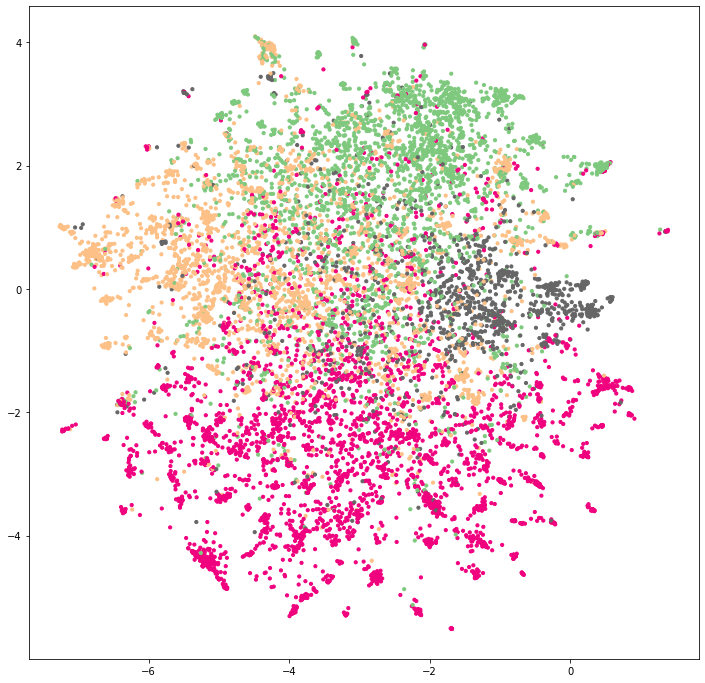

time: 770 ms


In [6]:
# Visualise TF-IDF embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_tfidf[:,0],
            embedding_tfidf[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.show()

### Google News w2v

In [8]:
# w2v specific setup
import gensim
import re

# Load w2v model
w2v_model_path = 'models/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_model_path, binary=True)

# Pre-process text functions, according to some reasonable rules
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

time: 47.3 s


In [18]:
# First pre-process the text
df['text_w2v'] = df.text.map(lambda x: clean_numbers(clean_text(x)))

# Create an average sentence vector
# If word not found, try lowercase
def sent2vec(x):
    summed_vector = np.zeros(300)
    words = x.split()
    cnt = 0
    for w in words:
        if w in w2v_model.vocab:
            summed_vector += w2v_model[w]
            cnt += 1
        else:
            if w.lower() in w2v_model.vocab:
                summed_vector += w2v_model[w.lower()]
                cnt += 1
    if cnt > 0:
        summed_vector = summed_vector / cnt
    return summed_vector

# Generate the w2v vectors
vectors_w2v = np.array([sent2vec(t) for t in df.text_w2v.tolist()])
print(vectors_w2v.shape)

(10000, 300)
time: 658 ms


In [19]:
# Generate the w2v dimension reduction
embedding_w2v = umap.UMAP(random_state=SEED).fit_transform(vectors_w2v)

time: 20.1 s


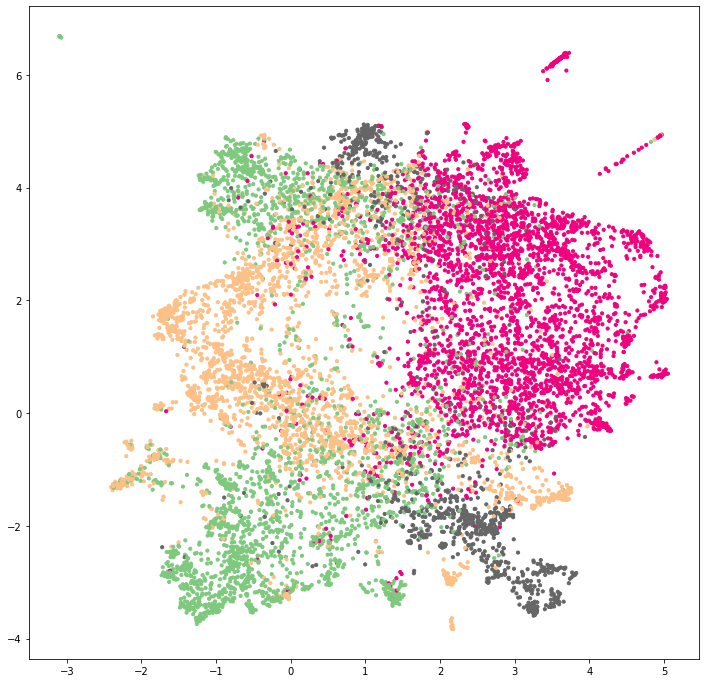

time: 762 ms


In [21]:
# Visualise w2v embeddings (cleaned)
plt.figure(figsize=(12,12))
plt.scatter(embedding_w2v[:,0],
            embedding_w2v[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.show()

### InferSent
https://github.com/facebookresearch/InferSent

```
# Infersent repo
mkdir git
git clone https://github.com/facebookresearch/InferSent.git git/InferSent

# Glove & Fasttext
mkdir models
curl -Lo models/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
unzip models/glove.840B.300d.zip -d models/
mkdir fastText
curl -Lo models/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
unzip models/crawl-300d-2M.vec.zip -d models/

# Infersent
curl -Lo models/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
curl -Lo models/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
```

In [16]:
# InferSent specific setup

# Add paths and fix working directory
INFERSENT_PATH = 'git/InferSent'
sys.path.append(INFERSENT_PATH)

# Imports
from models import InferSent
import torch

time: 2.55 ms


In [23]:
# Set model to v1 (GloVe)
MODEL_PATH = 'models/infersent1.pkl'
params_model = {'bsize': 64,
                'word_emb_dim': 300,
                'enc_lstm_dim': 2048,
                'pool_type': 'max',
                'dpout_model': 0.0,
                'version': 1}
infersent1 = InferSent(params_model)
infersent1.load_state_dict(torch.load(MODEL_PATH))

# Set model path
W2V_PATH = 'models/glove.840B.300d.txt'
infersent1.set_w2v_path(W2V_PATH)

# Build vocab
infersent1.build_vocab(sentences, tokenize=True)

# Generate InferSent vectors
vectors_infersent1 = infersent1.encode(sentences, tokenize=True)
print(vectors_infersent1.shape)

Found 17214(/18684) words with w2v vectors
Vocab size : 17214
(10000, 4096)
time: 1min 31s


In [24]:
# Generate InferSent dimensionality reduction
embedding_infersent1 = umap.UMAP(random_state=SEED).fit_transform(vectors_infersent1)

time: 25.8 s


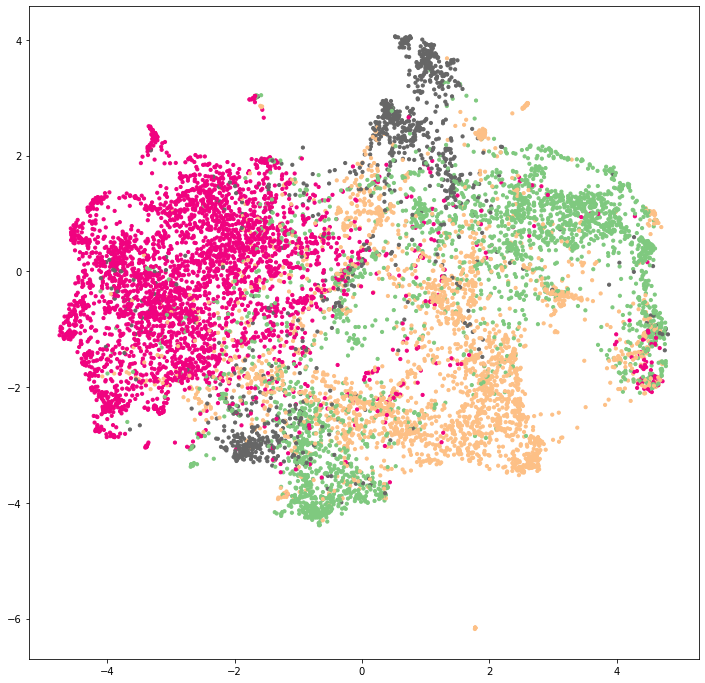

time: 655 ms


In [25]:
# Visualise InferSent embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_infersent1[:,0],
            embedding_infersent1[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)

plt.show()

In [29]:
idx = []
for i,y in enumerate(embedding_infersent1[:,1]):
    if y <-5: idx.append(i)
df.iloc[idx].head()

text cat  cat_id  \
5880    Titanfall launch hindered by Xbox Live sign-in...   t       1   
6180             The Titanfall Day 1 Update Is 840 MB Big   t       1   
996        Next-Gen Starts Tomorrow With Titanfall Launch   t       1   
1015    Titanfall Xbox One Resolution: Titanfall on Xb...   t       1   
213655                       Titanfall: Expedition review   t       1   

                                                 text_w2v  
5880    Titanfall launch hindered by Xbox Live sign in...  
6180             The Titanfall Day 1 Update Is ### MB Big  
996        Next Gen Starts Tomorrow With Titanfall Launch  
1015    Titanfall Xbox One Resolution Titanfall on Xbo...  
213655                        Titanfall Expedition review

time: 47.5 ms


In [26]:
# Set model to v2 (fasttext)
MODEL_PATH = 'models/infersent2.pkl'
params_model = {'bsize': 64,
                'word_emb_dim': 300,
                'enc_lstm_dim': 2048,
                'pool_type': 'max',
                'dpout_model': 0.0,
                'version': 2}
infersent2 = InferSent(params_model)
infersent2.load_state_dict(torch.load(MODEL_PATH))

# Set model path
W2V_PATH = 'models/crawl-300d-2M.vec'
infersent2.set_w2v_path(W2V_PATH)

# Build vocab
infersent2.build_vocab(sentences, tokenize=True)

# Generate InferSent vectors
vectors_infersent2 = infersent2.encode(sentences, tokenize=True)
print(vectors_infersent2.shape)

Found 17420(/18700) words with w2v vectors
Vocab size : 17420
(10000, 4096)
time: 1min 30s


In [27]:
# Generate InferSent dimensionality reduction
embedding_infersent2 = umap.UMAP(random_state=SEED).fit_transform(vectors_infersent2)

time: 26.7 s


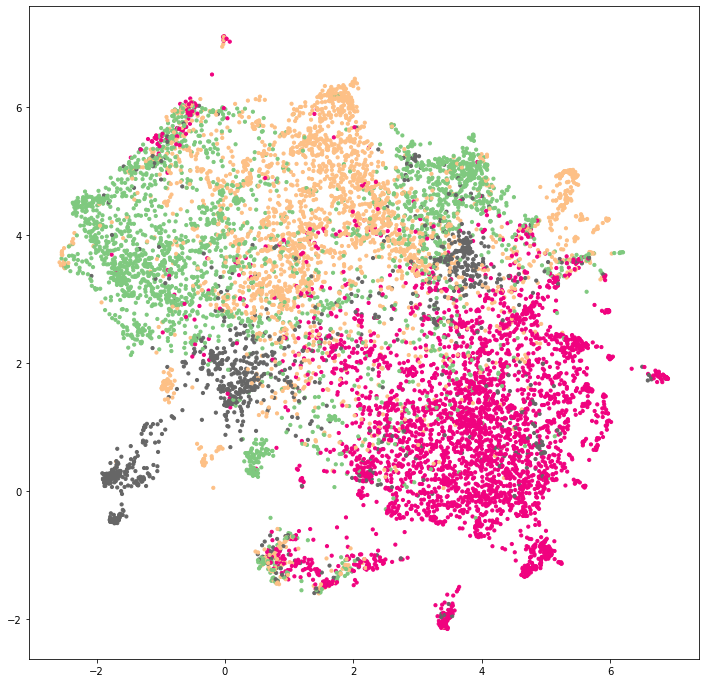

time: 650 ms


In [28]:
# Visualise InferSent embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_infersent2[:,0],
            embedding_infersent2[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)

plt.show()

### ELMo

* https://medium.com/@joeyism/embedding-with-tensorflow-hub-in-a-simple-way-using-elmo-d1bfe0ada45c
* https://towardsdatascience.com/elmo-contextual-language-embedding-335de2268604
* https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

In [4]:
# Tensorflow hub setup
import tensorflow_hub as hub
import tensorflow as tf

# Load ELMo model from Tensorflow Hub
elmo = hub.Module("https://tfhub.dev/google/elmo/2")

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


time: 20min 30s


In [ ]:
texts = df.text[0:10]
embeddings = elmo(x, signature="default", as_dict=True)["default"]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    vectors_elmo = sess.run(embeddings)

In [87]:
# Function which will take a list of strings (sentences) and return the ELMo vectors
def elmo_vectors(x):
  embeddings = elmo(x, signature="default", as_dict=True)["default"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(embeddings)

# Generate ELMo vectors - batch process 100 at a time
batch_size = 100
sentences_batch = [sentences[i:i+batch_size] for i in range(0,len(sentences),batch_size)]
vectors_elmo_batch = [elmo_vectors(x) for x in sentences_batch]
vectors_elmo = np.concatenate(vectors_elmo_batch, axis=0)

time: 59min 20s


In [92]:
# Generate ELMo dimension reductions
embedding_elmo = umap.UMAP(random_state=SEED).fit_transform(vectors_elmo)

time: 22.4 s


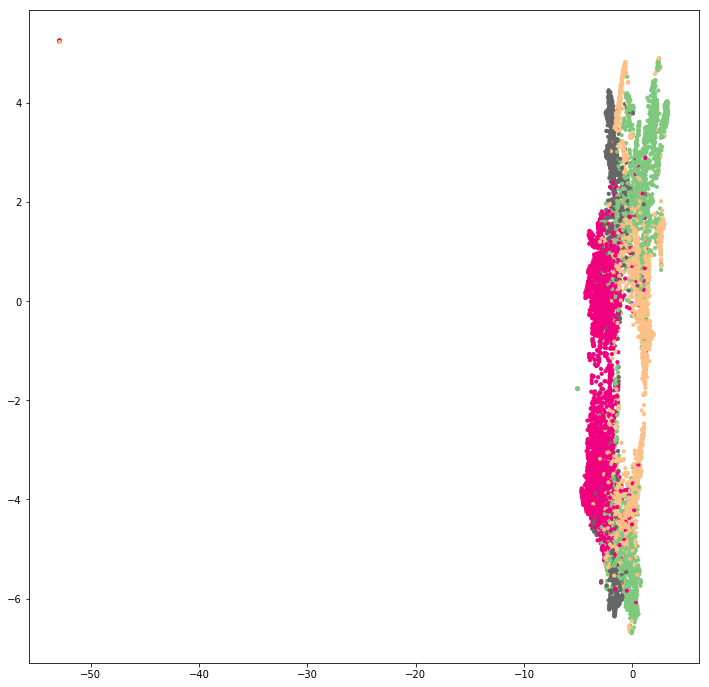

time: 635 ms


In [210]:
# Visualise the ELMo embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_elmo[:,0],
            embedding_elmo[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.show()

In [94]:
# Find ELMo outliers
idx = []
for i,x in enumerate(embedding_elmo[:,0]):
    if x < -50: idx.append(i)
df.iloc[idx].head()

text cat  cat_id  \
170123  YOUR FAMILY IS PRIORITY NUMBER ONE; TAKING CAR...   m       3   
301928                        HERE COME THE FED'S DOTS...   b       0   
141510             DANSKE BANK PREMIERSHIP LEAGUE RESULTS   t       1   
199607       CHINA BLAMES US FOR TENSIONS BETWEEN VIETNAM   b       0   
312869           Review: TEENAGE MUTANT NINJA TURTLES #35   e       2   

                                                 text_w2v  
170123  YOUR FAMILY IS PRIORITY NUMBER ONE TAKING CARE...  
301928                           HERE COME THE FED S DOTS  
141510             DANSKE BANK PREMIERSHIP LEAGUE RESULTS  
199607       CHINA BLAMES US FOR TENSIONS BETWEEN VIETNAM  
312869             Review TEENAGE MUTANT NINJA TURTLES ##

time: 35.2 ms


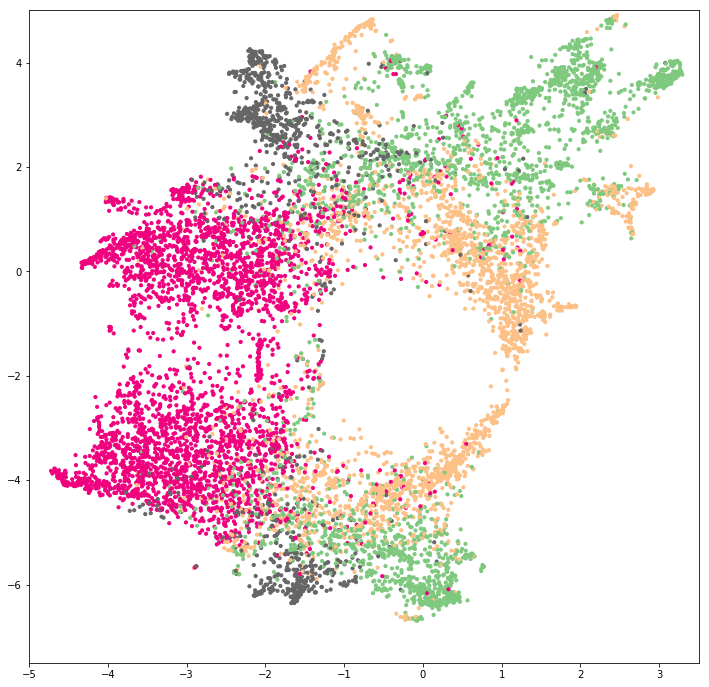

time: 750 ms


In [209]:
plt.figure(figsize=(12,12))
plt.scatter(embedding_elmo[:,0],
            embedding_elmo[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.xlim(-5,3.5)
plt.ylim(-7.5,5)
plt.show()

### Google Universal Sentence Encoded (GUSE) - L (Transformer)

* https://tfhub.dev/google/universal-sentence-encoder/2
* https://tfhub.dev/google/universal-sentence-encoder-large/3

In [8]:
# Tensorflow hub setup
import tensorflow_hub as hub
import tensorflow as tf

# Load Google model from Tensorflow Hub
guse = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

time: 7min 31s


In [10]:
text = ["We're at DSGO 2019!", "Generating some vectors"]
embeddings = guse(text)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    vectors = sess.run(embeddings)
print(vectors.shape)

(2, 512)
time: 6.2 s


In [226]:
# Function which will take a list of strings (sentences) and return the GUSE vectors
def guse_vectors(x):
  embeddings = guse(x)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    return sess.run(embeddings)

# Generate GUSE vectors - batch process 1000 at a time
batch_size = 2000
sentences_batch = [sentences[i:i+batch_size] for i in range(0,len(sentences),batch_size)]
vectors_guse_batch = [guse_vectors(x) for x in sentences_batch]
vectors_guse = np.concatenate(vectors_guse_batch, axis=0)

time: 47min 28s


In [158]:
# Generate the GUSE dimension reductions
embedding_guse = umap.UMAP(random_state=SEED).fit_transform(vectors_guse)

time: 21.1 s


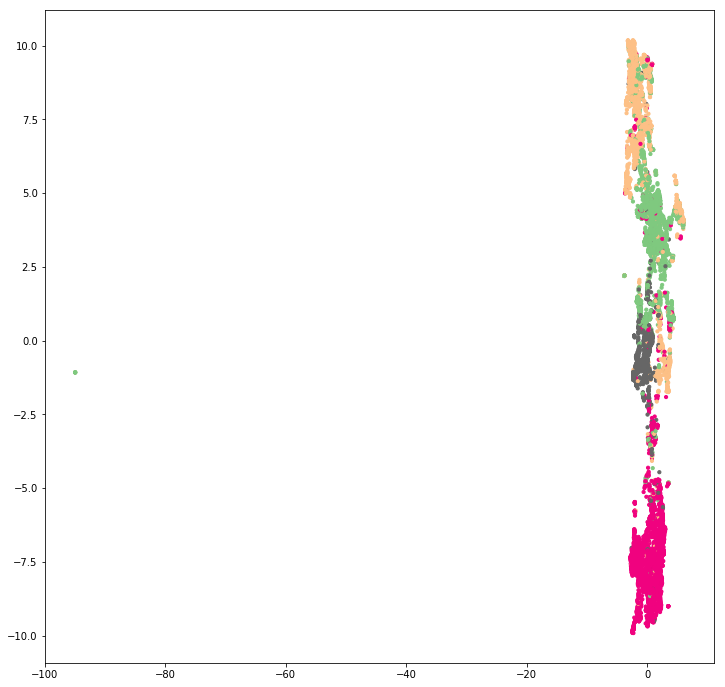

time: 972 ms


In [230]:
# Visualise GUSE embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_guse[:,0],
            embedding_guse[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.show()

In [231]:
# Find GUSE-L outliers
idx = []
for i,x in enumerate(embedding_guse[:,0]):
    if x < -80: idx.append(i)
df.iloc[idx].head()

text cat  cat_id  \
247497                Posted by Shoaib-ur-Rehman Siddiqui   b       0   
361343                Posted by Shoaib-ur-Rehman Siddiqui   b       0   
263705  'Oleg Pliss' hack makes for a perfect teachabl...   t       1   
285625                           Posted by Muhammad Iqbal   b       0   
245218                           Posted by Muhammad Iqbal   b       0   

                                                 text_w2v  \
247497                Posted by Shoaib ur Rehman Siddiqui   
361343                Posted by Shoaib ur Rehman Siddiqui   
263705   Oleg Pliss  hack makes for a perfect teachabl...   
285625                           Posted by Muhammad Iqbal   
245218                           Posted by Muhammad Iqbal   

                                                text_w2v2   idx  
247497                Posted by Shoaib ur Rehman Siddiqui  1438  
361343                Posted by Shoaib ur Rehman Siddiqui  2453  
263705  Oleg Pliss hack makes for a perfect teachable ...  5228  
285625                           Posted by Muhammad Iqbal  5945  
245218                           Posted by Muhammad Iqbal  6857

time: 265 ms


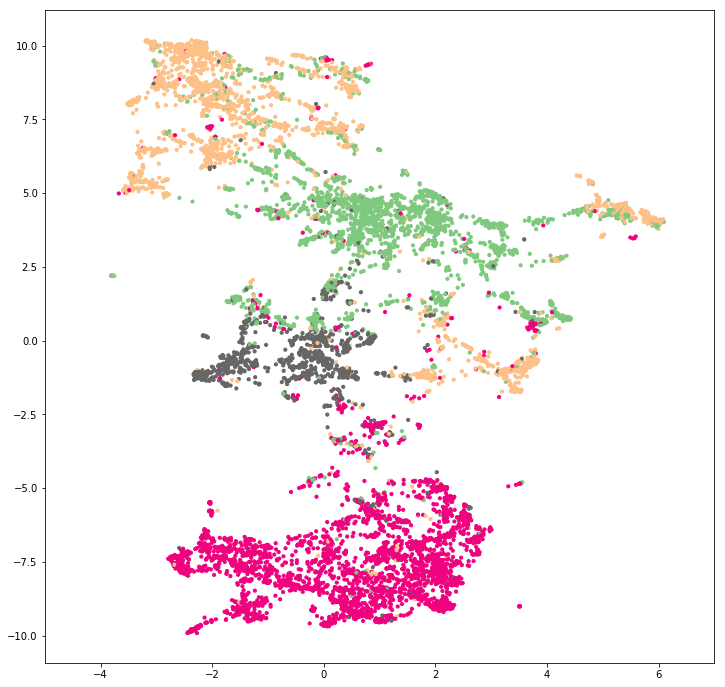

time: 726 ms


In [232]:
# Visualise GUSE embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_guse[:,0],
            embedding_guse[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.xlim(-5,7)
plt.show()

In [168]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
init_notebook_mode(connected=True)

time: 4.45 ms


In [235]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

# Plotly
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    xaxis=dict(range=[-5, 7]),
    hovermode="closest"
)

data = [go.Scatter(
                x=embedding_guse[:,0],
                y=embedding_guse[:,1],
                text=df.text,
                mode='markers',
                marker=dict(
                        size=4,
                        colorscale=matplotlib_to_plotly(plt.cm.Accent, 255),
                        color=df.cat_id,
                        showscale=False
                )
)]

fig = go.Figure(data=data, layout=layout)

p = iplot(fig)

time: 1.09 s


### BERT (bert-as-a-service)

* https://github.com/hanxiao/bert-as-service

After installing you will need to start a server. This example uses the default parameters on the smaller uncased  model (`uncased_L-12_H-768_A-12`) with 4 workers.

In [76]:
# BERT specific setup
from bert_serving.client import BertClient
bc = BertClient()

time: 456 ms


In [77]:
# Generate BERT vectors
vectors_bert = bc.encode(sentences)

time: 8min 3s


In [78]:
# Generate the BERT dimension reductions
embedding_bert = umap.UMAP(random_state=SEED).fit_transform(vectors_bert)

/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


time: 21.4 s


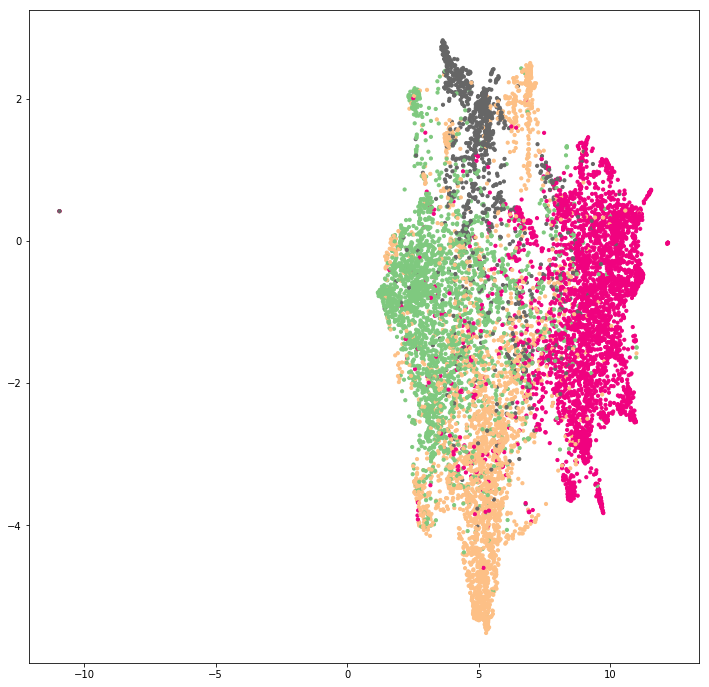

time: 678 ms


In [204]:
# Visualise BERT embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_bert[:,0],
            embedding_bert[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.show()

In [85]:
# Find BERT outliers
idx = []
for i,x in enumerate(embedding_bert[:,0]):
    if x < -10: idx.append(i)
df.iloc[idx].head()

text cat  cat_id  \
318382  10 Things to Know for Thursday   t       1   
91445      10 Things to Know for Today   b       0   
98315      10 Things to Know for Today   e       2   
265412     10 Things to Know for Today   e       2   
162520     10 Things to Know for Today   m       3   

                              text_w2v  
318382  ## Things to Know for Thursday  
91445      ## Things to Know for Today  
98315      ## Things to Know for Today  
265412     ## Things to Know for Today  
162520     ## Things to Know for Today

time: 34.7 ms


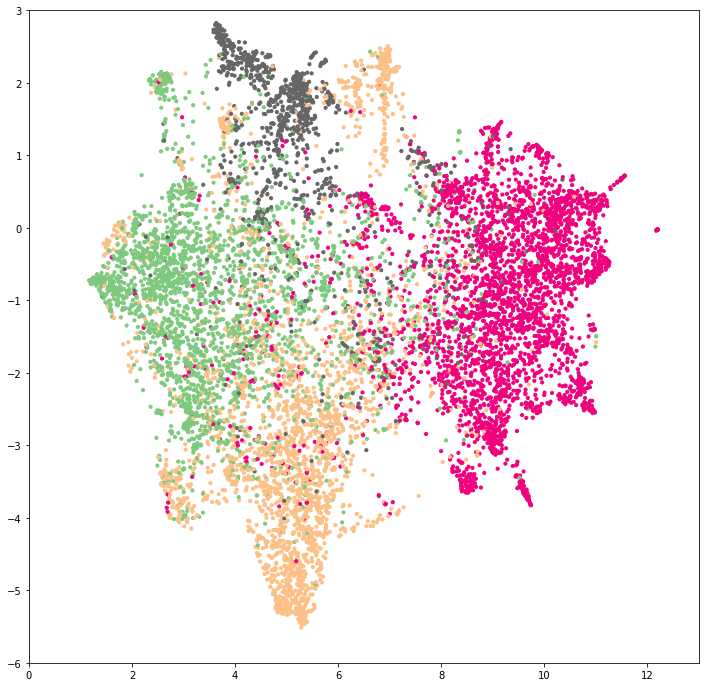

time: 715 ms


In [203]:
# Visualise BERT embeddings
plt.figure(figsize=(12,12))
plt.scatter(embedding_bert[:,0],
            embedding_bert[:,1],
            s=10,
            c=df.cat_id,
            cmap=plt.cm.Accent)
plt.xlim(0,13)
plt.ylim(-6,3)
plt.show()

# 2) Compare them all

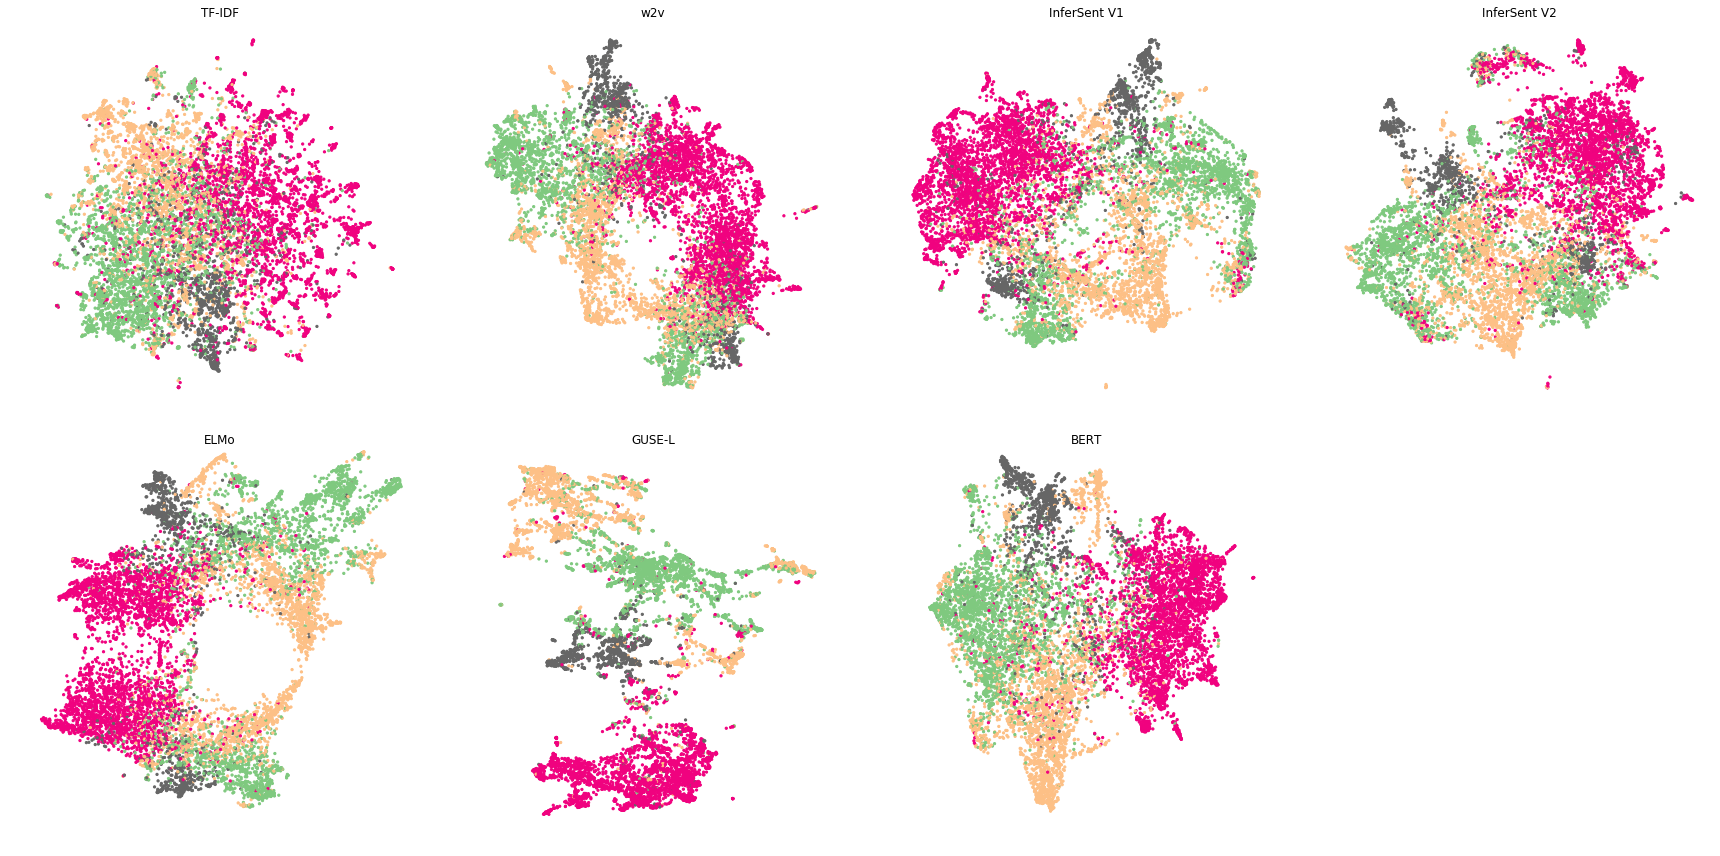

time: 3.49 s


In [234]:
cm = plt.cm.Accent

plt.figure(figsize=(24,12), facecolor='w')

plt.subplot(2,4,1)
plt.scatter(embedding_tfidf[:,0],
            embedding_tfidf[:,1],
            s=5,
            c=df.cat_id,
            cmap=cm)
plt.title("TF-IDF")
plt.axis("off")

plt.subplot(2,4,2)
plt.scatter(embedding_w2v[:,0],
            embedding_w2v[:,1],
            s=5,
            c=df.cat_id,
            cmap=cm)
plt.xlim(-2,10)
plt.title("w2v")
plt.axis("off")

plt.subplot(2,4,3)
plt.scatter(embedding_infersent1[:,0],
            embedding_infersent1[:,1],
            s=5,
            c=df.cat_id,
            cmap=cm)
plt.title("InferSent V1")
plt.axis("off")

plt.subplot(2,4,4)
plt.scatter(embedding_infersent2[:,0],
            embedding_infersent2[:,1],
            s=5,
            c=df.cat_id,
            cmap=cm)
plt.title("InferSent V2")
plt.axis("off")

plt.subplot(2,4,5)
plt.scatter(embedding_elmo[:,0],
            embedding_elmo[:,1],
            s=5,
            c=df.cat_id,
            cmap=cm)
plt.xlim(-5,3.5)
plt.ylim(-7.5,5)
plt.title("ELMo")
plt.axis("off")

plt.subplot(2,4,6)
plt.scatter(embedding_guse[:,0],
            embedding_guse[:,1],
            s=5,
            c=df.cat_id,
            cmap=cm)
plt.xlim(-5,7)
plt.title("GUSE-L")
plt.axis("off")

plt.subplot(2,4,7)
plt.scatter(embedding_bert[:,0],
            embedding_bert[:,1],
            s=5,
            c=df.cat_id,
            cmap=cm)
plt.xlim(0,13)
plt.ylim(-6,3)
plt.title("BERT")
plt.axis("off")

plt.tight_layout()
plt.show()

# General tokenizing

In [2]:
text = "Hello! I can't believe I am running a workshop at DSGO."

time: 899 µs


In [3]:
import nltk.tokenize
for token in nltk.tokenize.word_tokenize(text):
    print(token)

Hello
!
I
ca
n't
believe
I
am
running
a
workshop
at
DSGO
.
time: 596 ms


In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
for token in doc:
    print(token)

Hello
!
I
ca
n't
believe
I
am
running
a
workshop
at
DSGO
.
time: 764 ms


In [5]:
import string
for token in doc:
    clean_token = token.lemma_.lower()
    if clean_token not in string.punctuation:
        print(clean_token)

hello
-pron-
can
not
believe
-pron-
be
run
a
workshop
at
dsgo
time: 2.79 ms


In [6]:
for token in doc:
    clean_token = token.lemma_.lower()
    if  clean_token not in string.punctuation and\
        clean_token != '-pron-' and\
        clean_token not in nltk.corpus.stopwords.words('english'):
            
        print(clean_token) 

hello
believe
run
workshop
dsgo
time: 13.1 ms
